In [ ]:
!tar zxvf './lens_data_alt.tgz' -C './data/'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from keras.engine import data_adapter
import matplotlib.pyplot as plot
import csv
import pandas as pd
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import os
import sys
import random
import math

In [3]:
SEED = 0
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
BASEPATH = './data/lens_data' # Location of data
MODELPATH = './weights' # Location of weights
BATCH_SIZE = 128
EPOCHS = 300
LEARNING_RATE = 2e-5

In [5]:
def load_train_data():
  image_files = os.listdir(BASEPATH)

  x, y = [], []
  for filename in image_files:
    temp = np.load(os.path.join(BASEPATH, filename), allow_pickle=True)
    if len(temp) != 2:
      continue
    x_temp, y_temp = temp[0], temp[1]
    x.append(x_temp)
    y.append(y_temp)
  
  x = np.expand_dims(np.stack(x, axis=0), axis=-1) # Add channel axis
  y = np.stack(y, axis=0)

  np.save(os.path.join(BASEPATH, 'X.npy'), x)
  np.save(os.path.join(BASEPATH, 'Y.npy'), y)

  return x, y

In [6]:
# Load train data
X_TRAIN, Y_TRAIN = load_train_data()

# Standardize data
X_TRAIN = ((X_TRAIN - np.mean(X_TRAIN, axis=(1, 2), keepdims=True))
          / np.std(X_TRAIN, axis=(1, 2), keepdims=True))

# Shuffle train data
perm = np.random.permutation(len(X_TRAIN))
X_TRAIN, Y_TRAIN = X_TRAIN[perm], Y_TRAIN[perm]

# Train / Val split
val_size = len(X_TRAIN) // 10
X_VAL, Y_VAL = X_TRAIN[:val_size], Y_TRAIN[:val_size]
X_TRAIN, Y_TRAIN = X_TRAIN[val_size:], Y_TRAIN[val_size:]

In [7]:
def make_model(image_shape):
  image_inputs = keras.Input(shape=image_shape)
  x = keras.Sequential([
                        layers.RandomFlip(),
                        layers.RandomRotation(0.5)
                        ])(image_inputs)
  
  x = layers.Conv2D(16, 5)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  for _ in range(3):
    x = layers.Conv2D(32, 3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
  
  for _ in range(2):
    residual = layers.Conv2D(64, 1)(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.add([x, residual])

  x = layers.Conv2D(128, 3)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Flatten()(x)

  x = layers.Dense(256, kernel_regularizer=regularizers.l2(1e-3))(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dense(64, kernel_regularizer=regularizers.l2(1e-3))(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dense(1)(x)
  outputs = layers.LeakyReLU()(x)

  return keras.Model(image_inputs, outputs)

In [8]:
class TrackBestPerformance(keras.callbacks.Callback):
  """
  Callback to keep track of model weights which give best val_auc
  After training completes, the model is assigned with the best model weights
  """
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.best_mse = 1
    self.best_epoch = -1
    self.best_weights = None
  
  def on_epoch_end(self, epoch, logs=None):
    current_mse = logs['val_mse']
    if current_mse <= self.best_mse:
      self.best_mse = current_mse
      self.best_epoch = epoch
      self.best_weights = self.model.get_weights()
  
  def on_train_end(self, logs=None):
    self.model.set_weights(self.best_weights)
    print(f'Best validation MSE is {self.best_mse} on epoch #{self.best_epoch + 1}')


In [9]:
model = make_model(X_TRAIN.shape[1:])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=keras.losses.MeanSquaredError(reduction=keras.losses.Reduction.SUM),
              metrics=[keras.metrics.MeanSquaredError(name='mse'),
                       keras.metrics.RootMeanSquaredError(name='rmse')])

history = model.fit(X_TRAIN, Y_TRAIN, validation_data=(X_VAL, Y_VAL),
                    epochs=EPOCHS,
                    callbacks=[TrackBestPerformance()])

Epoch 1/300
563/563 [==============================] - 36s 45ms/step - loss: 1.1763 - mse: 0.0178 - rmse: 0.1334 - val_loss: 0.7967 - val_mse: 0.0060 - val_rmse: 0.0776
Epoch 2/300
563/563 [==============================] - 25s 44ms/step - loss: 0.7325 - mse: 0.0041 - rmse: 0.0637 - val_loss: 0.7266 - val_mse: 0.0040 - val_rmse: 0.0630
Epoch 3/300
563/563 [==============================] - 25s 44ms/step - loss: 0.6861 - mse: 0.0028 - rmse: 0.0527 - val_loss: 0.6945 - val_mse: 0.0031 - val_rmse: 0.0560
Epoch 4/300
563/563 [==============================] - 25s 44ms/step - loss: 0.6643 - mse: 0.0023 - rmse: 0.0479 - val_loss: 0.6598 - val_mse: 0.0023 - val_rmse: 0.0477
Epoch 5/300
563/563 [==============================] - 25s 44ms/step - loss: 0.6451 - mse: 0.0019 - rmse: 0.0439 - val_loss: 0.6576 - val_mse: 0.0025 - val_rmse: 0.0496
Epoch 6/300
563/563 [==============================] - 25s 44ms/step - loss: 0.6347 - mse: 0.0019 - rmse: 0.0433 - val_loss: 0.6825 - val_mse: 0.0035 - val

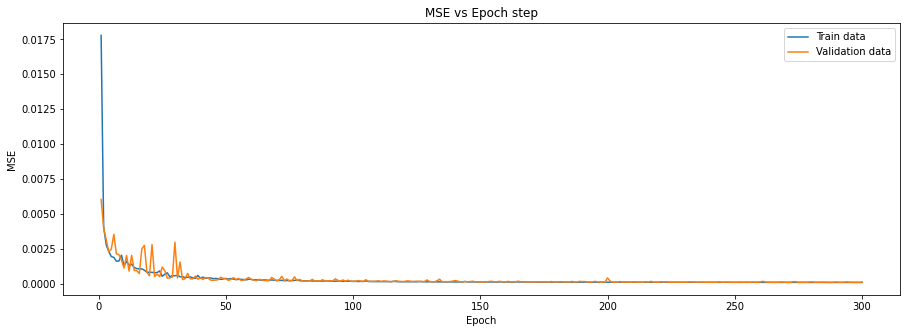

In [10]:
_, axes = plot.subplots(figsize=(15, 5))
_ = axes.plot(range(1, EPOCHS + 1), history.history['mse'], label='Train data')
_ = axes.plot(range(1, EPOCHS + 1), history.history['val_mse'], label='Validation data')
_ = axes.set(xlabel='Epoch', ylabel='MSE', title='MSE vs Epoch step')
_ = plot.legend()

In [11]:
print('Best validation MSE: {}'.format(min(history.history['val_mse'])))
print('Corresponding train MSE: {}'.format(history.history['mse'][np.argmin(history.history['val_mse'])]))

Best validation MSE: 8.0275465734303e-05
Corresponding train MSE: 7.809164526406676e-05


In [12]:
X_BATCHES_TRAIN = np.array_split(X_TRAIN, 50, axis=0)
Y_PRED_TRAIN = np.concatenate([model(x_batch).numpy() for x_batch in X_BATCHES_TRAIN], axis=0)[:, 0]

X_BATCHES_VAL = np.array_split(X_VAL, 50, axis=0)
Y_PRED_VAL = np.concatenate([model(x_batch).numpy() for x_batch in X_BATCHES_VAL], axis=0)[:, 0]

In [13]:
# Save model weights
model.save(MODELPATH)

INFO:tensorflow:Assets written to: /content/weights/assets


In [14]:
# Compress model weights
!zip -r './test_3_weights.zip' './weights'

  adding: content/weights/ (stored 0%)
  adding: content/weights/variables/ (stored 0%)
  adding: content/weights/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/weights/variables/variables.index (deflated 75%)
  adding: content/weights/assets/ (stored 0%)
  adding: content/weights/keras_metadata.pb (deflated 94%)
  adding: content/weights/saved_model.pb (deflated 89%)


In [15]:
# Load model weights
model = keras.models.load_model(MODELPATH)

In [16]:
_ = model.evaluate(X_VAL, Y_VAL)

63/63 [==============================] - 1s 9ms/step - loss: 0.0034 - mse: 8.0275e-05 - rmse: 0.0090


In [ ]:
# Run this cell to evaluate on test data
X_TEST, Y_TEST = None, None # load test data here. Shape: (None, 150, 150, 1)

# Standardize test data
X_TEST = ((X_TEST - np.mean(X_TEST, axis=(1, 2), keepdims=True))
          / np.std(X_TEST, axis=(1, 2), keepdims=True))

model.evaluate(X_TEST, Y_TEST)